# Predicting CMS Prevalence of Diabetes at County Level based on AHRQ Social Determinants of Health


__[GitHub: SocialHealthAI/CMS-CDC-SDOH](https://github.com/SocialHealthAI/CMS-CDC-SDOH)__

## Overview
Studies show a strong correlation between social determinants of health and mental/physical health. __[County Health Rankings, Relationships Between Determinant Factors
and Health Outcomes](https://www.ajpmonline.org/article/S0749-3797(15)00514-0/fulltext)__ provides a detailed analysis of social features correlated to premature death, low birth weight and poor mental/physical health.  

''<img src='./diabetes_ohio.png' title='Ohio Diabetes Prevalence and Social Vulnerability Index' />

The target for the models is the prevalence (percent) of diabetes based in a county.  Prevalence data is obtained from the Center of Medicare and Medicaid Services (CMS) diabetes claims.  The features used to predict the target are social determinants of health (SDOH).  SDOH features are obtained from the  Agency for Healthcare Research and Quality (AHRQ).

## Benefits
The models can be used in several ways:
- Ranking the important SDOH features for a county.
- Predicting the CMS prevalence based on SDOH features changes.
- Predicting the CMS prevalence when new AHRQ SDOH data is available.

# Set up Environment

In [1]:
%run ./environment/env1.ipynb

# Extract, transform and load data

## CMS Diabetes Claims
Call CMS Chronic Data notebook using year and disease parameters.

In [2]:
parm_CMSChronic_disease = 'Diabetes'
parm_CMSChronic_years = ['2015', '2016', '2017', '2018']
%run ./ETL/dataCMSChronic.ipynb
dfCMSChronicPrevalence = out_CMSChronic()

## Explore CMS Data
Show prevalence in sorted barchart for particular state.

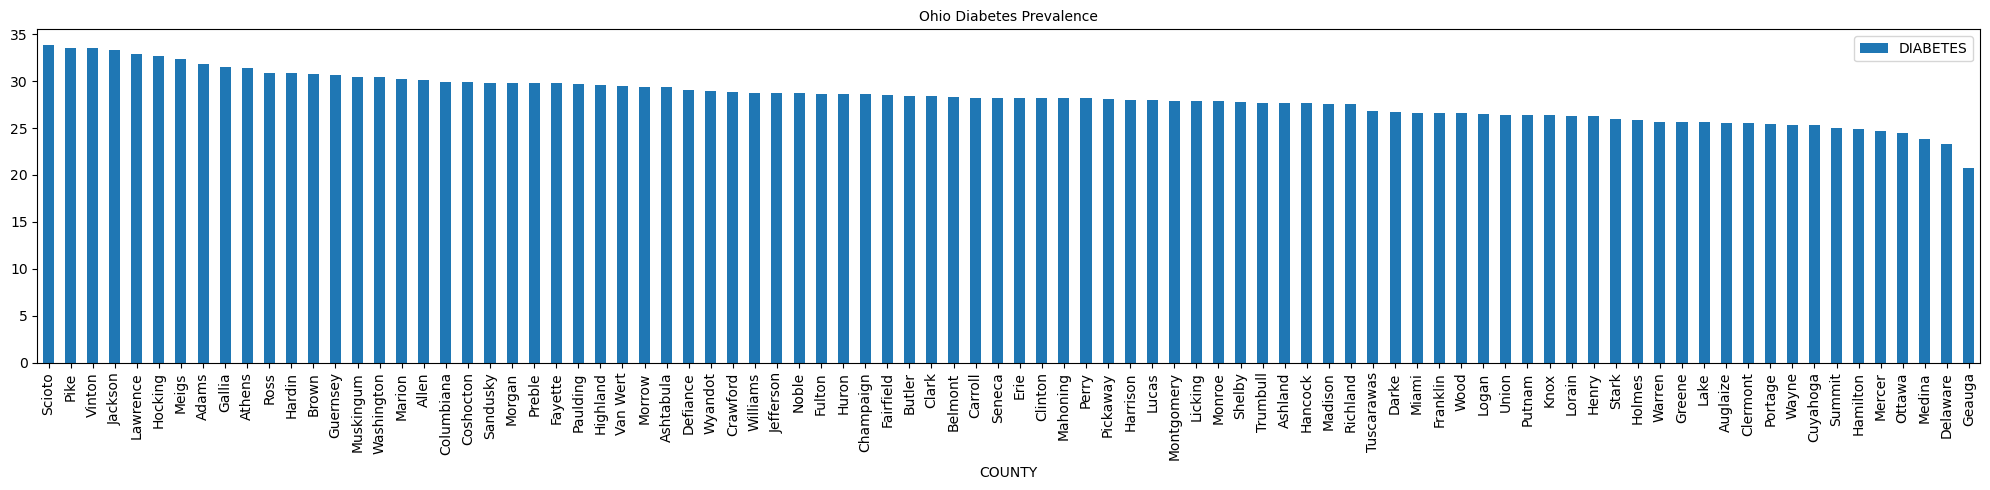

In [10]:
dfDisplay = dfCMSChronicPrevalence[(dfCMSChronicPrevalence.STATE == 'Ohio') & (dfCMSChronicPrevalence.YEAR == 2018)]
dfDisplay= dfDisplay.sort_values('DIABETES',ascending=False)
dfDisplay.plot(x="COUNTY", y="DIABETES", kind="bar", figsize=(20,5))
plt.title("Ohio Diabetes Prevalence", fontsize=10)
plt.tight_layout()
plt.show()

## AHRQ Data
Call AHRQ SDOH Data notebook using year parameter.

In [11]:
parm_AHRQCountySDOH_years = ['2015', '2016', '2017', '2018']
# currently not including NOAAC - temperature by month
parm_AHRQCountySDOH_surveys = ["ACS", "AHA", "AMFAR", "CCBP", "CDCSVI", "CEN", "CRDC", "EPAA", "FARA", "FEA", "HHC", "HIFLD", "HRSA", "MHSVI", "MP", "NCHS", "NEPHTN", "NHC", "NOAAS", "POS", "SAHIE", "SAIPE", "SEDA"]
parm_AHRQCountySDOH_questions = ["CDCW_INJURY_DTH_RATE", "CDCW_TRANSPORT_DTH_RATE", "CDCW_SELFHARM_DTH_RATE", "CDCW_ASSAULT_DTH_RATE", "CHR_TOT_MENTAL_PROV", "CHR_MENTAL_PROV_RATE", "CHR_SEGREG_BLACK", "CHR_PCT_ALCOHOL_DRIV_DEATH", "CHR_PCT_EXCESS_DRINK", "CHR_PCT_FOOD", "CHR_SEGREG_BLACK", "CHR_SEGREG_NON_WHITE"]
%run ./ETL/dataAHRQCountySDOH.ipynb
dfAHRQCountySDOH = out_AHRQCountySDOH()

## Explore AHRQ Data
Show correlations for food related SDOH.

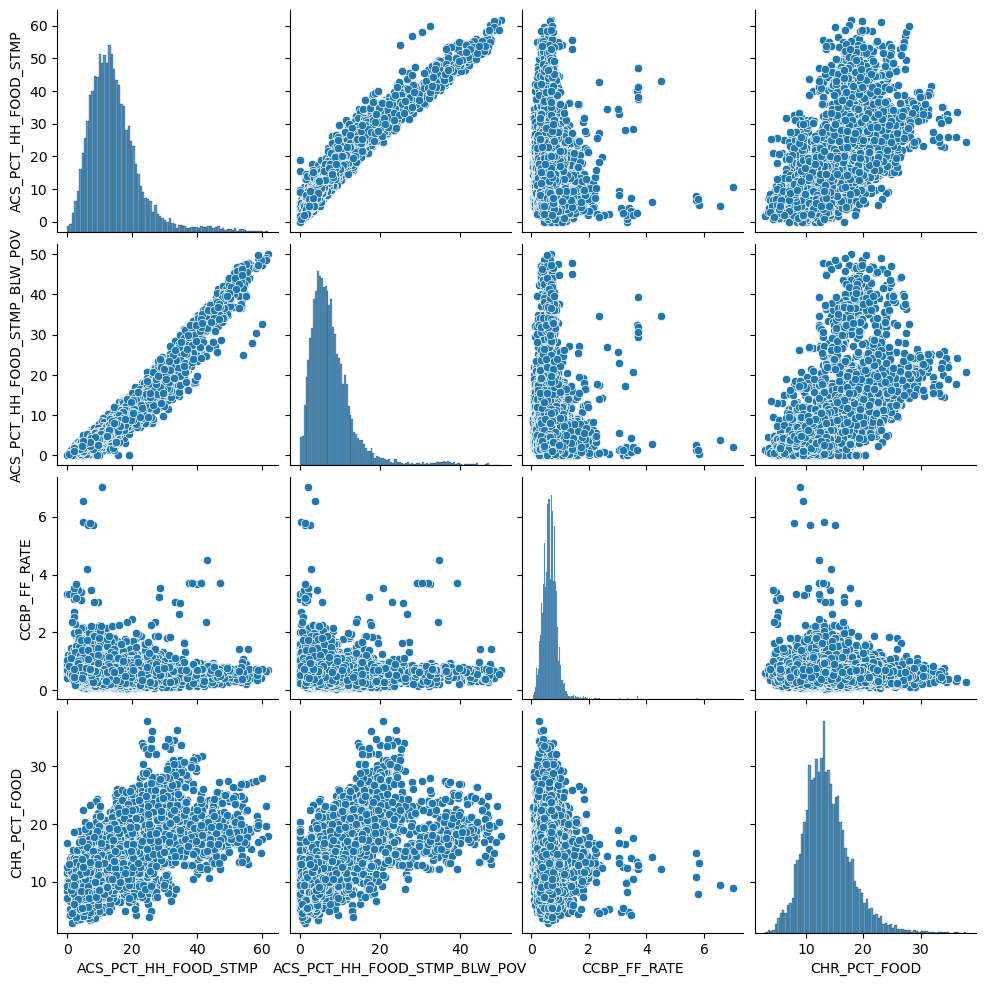

In [12]:
dfAHRQFood = dfAHRQCountySDOH[['STATE', 'COUNTY', 'ACS_PCT_HH_FOOD_STMP', 'ACS_PCT_HH_FOOD_STMP_BLW_POV' , 'CCBP_FF_RATE', 'CHR_PCT_FOOD']]
sns.pairplot(dfAHRQFood)

## Merge Data and Create Training, Test sets

In [13]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] < 2018]

X = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y = dfMerged["DIABETES"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size = 0.2, random_state = 42)
pd.set_option('display.max_rows', 20)
dfMerged.isnull().sum()

STATE                    0
COUNTY                   0
YEAR                     0
ACS_TOT_POP_WT           0
ACS_TOT_POP_US_ABOVE1    0
                        ..
CHR_PCT_EXCESS_DRINK     0
CHR_PCT_FOOD             0
CHR_SEGREG_NON_WHITE     0
FIPS                     0
DIABETES                 0
Length: 481, dtype: int64

# Feature Selection

## Random Forest Regressor feature selection

R2 Score:  0.9805500476019521


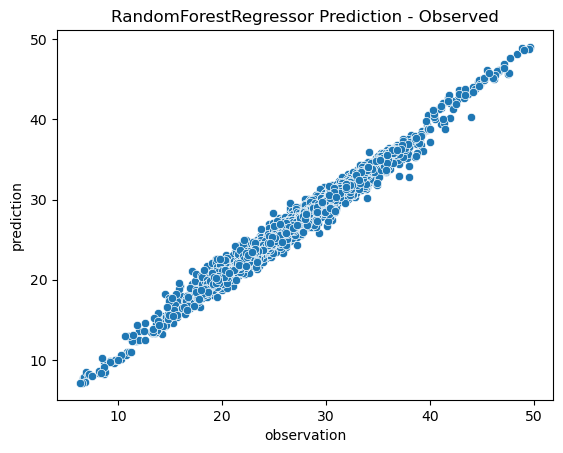

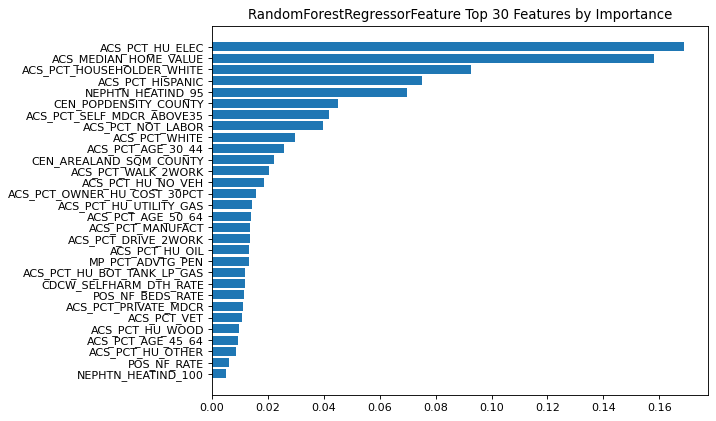

R2 Score:  0.9805500476019521


In [26]:
parm_features_RandomForestReg_X = X_train # features dataframe
parm_features_RandomForestReg_Y = Y_train # target dataframe

%run features_RandomForestReg.ipynb
listSelectedFeatures = out_features_RandomForestReg_X()
print("R2 Score: ", out_features_RandomForestReg_X_R2())

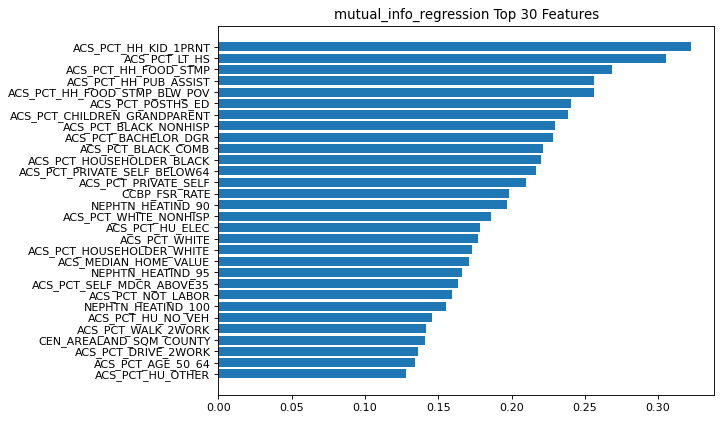

In [18]:
parm_features_MutualInformationReg_X = X_train # features dataframe
parm_features_MutualInformationReg_Y = Y_train # target dataframe
%run features_MutualInformationReg.ipynb
listSelectedFeatures = out_features_MutualInformationReg_X()[0:30]

In [29]:
X_train_selected = X_train[listSelectedFeatures]
X_test_selected = X_test[listSelectedFeatures]
X_train_selected

,ACS_PCT_HISPANIC,CEN_POPDENSITY_COUNTY,ACS_PCT_NOT_LABOR,ACS_PCT_SELF_MDCR_ABOVE35,NEPHTN_HEATIND_95,ACS_MEDIAN_HOME_VALUE,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HU_ELEC
5501,19.88,26.22,42.53,4.85,119.0,154700.0,91.45,58.68
8000,5.56,563.44,40.70,3.42,5.0,99300.0,82.47,12.78
7912,0.30,2.24,44.47,14.97,11.0,92200.0,96.04,31.25
3514,33.50,356.88,35.95,2.84,64.0,120200.0,90.65,83.01
7074,2.23,76.35,40.56,3.71,28.0,130500.0,88.11,42.13
...,...,...,...,...,...,...,...,...
5734,1.99,29.27,49.61,5.17,55.0,109100.0,47.69,60.13
5191,1.36,113.33,43.20,7.23,12.0,99700.0,98.38,21.03
5390,4.83,83.46,39.60,4.20,58.0,114700.0,91.20,63.99
860,14.00,30.60,34.07,6.22,52.0,81200.0,94.08,13.57


# Develop Models and Evaluate Performance

## Linear Regression

In [28]:
# define the model
lr = LinearRegression()
lr.fit(X_train_selected, Y_train)

# Coefficient of Determination
lr.score(X_test_selected,Y_test)

0.5145971202166794

## Random Forest
Random Forest can handle missing data.

In [25]:
# define the model
rf = RandomForestRegressor(n_estimators= 100, random_state=5)
# fit the random forest model
rf.fit(X_train, Y_train)

# Coefficient of Determination
#rf.score(X_test,Y_test)

RandomForestRegressor(random_state=5)

R2 Score:  0.8790877114901527


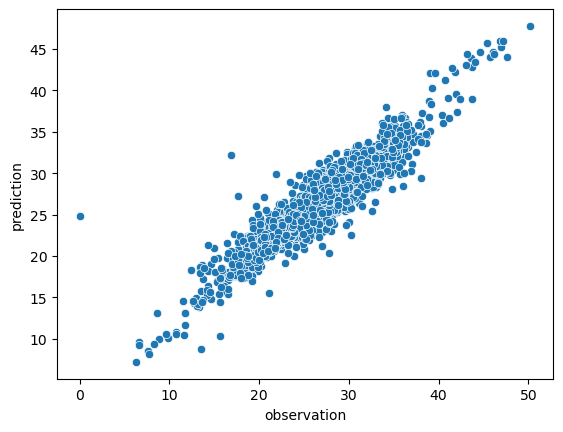

In [26]:
Y_pred = rf.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees
XGBoost can handle missing data.

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0).fit(X_train, Y_train)
#xgb.score(X_test, Y_test)

R2 Score:  0.7617223248908053


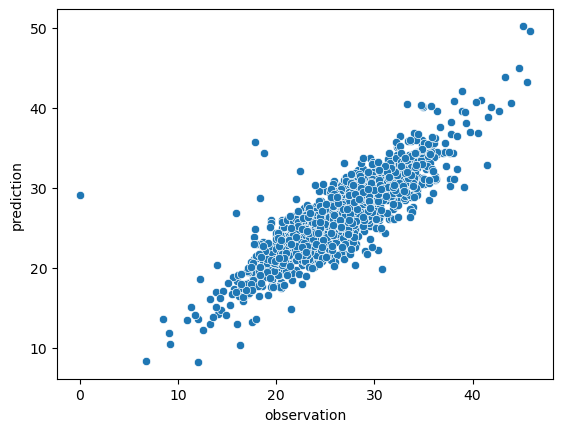

In [18]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Evaluate performance future year

### Create test sets for future year

In [19]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] == 2018]

X_test = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
X_test = X_test[listSelectedFeaures]

Y_test = dfMerged["DIABETES"]

## Regression

In [20]:
# define the model
lr = LinearRegression()
lr.fit(X_test, Y_test)

# Coefficient of Determination
lr.score(X_test,Y_test)

0.728841484015162

## Random Forest

R2 Score:  0.8786116502899346


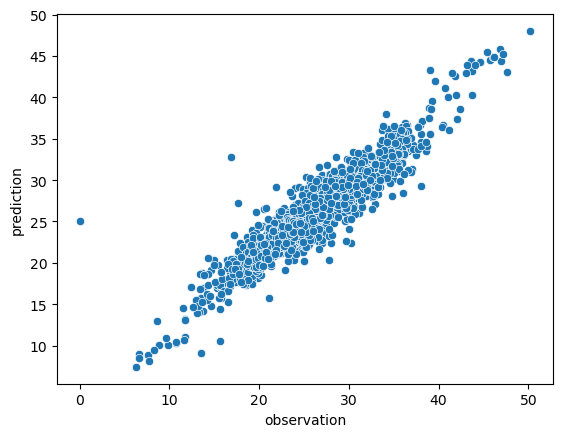

In [21]:
Y_pred = rf.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees

R2 Score:  0.7754475060655979


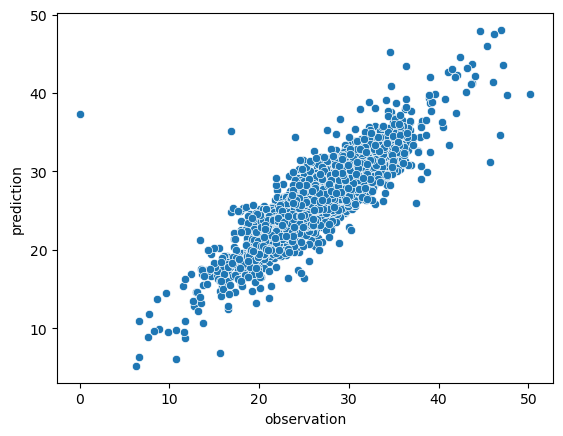

In [22]:
Y_pred = xgb.predict(X_test)
print("R2 Score: ", r2_score(Y_test,Y_pred))

list = Y_test.tolist()
scatterplot(x=list, y=Y_pred)
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Publish Models